# Make Dataset
This notebook uses tensorflow-io to load and pre-process audio files. It also makes the desired cuts in the data to create the dataset from a given audio file.

For some reason, all the libraries I use a very sensitive to different versions of each other, so for the sake of reproducibility, here are the versions of the packages I used:
- Python == 3.10.10
- tensorflow == 2.11.0
- tensorflow-io == 0.31.0
- Numpy == 1.23.5
- Matplotlib == 3.7.1
- Jupyter Notebook == 6.5.3

NB: Since we only treated individual audio files during the internship, I used a simple numpy array to store and manipulate the dataset. When data becomes bigger, this approach is too memory-heavy and one should look into using the "dataset" API from tensorflow that allows efficient handling of large dataset as well as built-in compatibility with models that would reduce the data-loading bottleneck during training.

NB 2: The network used needed for the pixel dimensions of data points to be divisible by 8. The shape was thus chosen to be the closest 8-multiples from 5 seconds time window and 0 to 5000 Hz frequency window.

# 1. Import and pre-process


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio

path = 'full_audio_files/P.wav'     #Path for the audio file
key = "P"                           # The key that will be used to create all the files

# Parameters
base_sr = 44100                 # Baseline sample rate, I recommend 44100Hz.
nb_samples = 300                #Number of datapoints to make


# NB: duration was replaced by the closest multiple of 8 (in numbers of pixels). This is because our network is downsampling the image by a factor 8 and can't handle non-multiples yet. Changes will have to be made to the definition of the dense layer in the DECODER to account for this
#duration = 5            #Duration of the datapoints in seconds
#NB: We try to limit nb_samples*duration > total duration of the audio clip to avoid random over-representation of some parts of the audio clip

## 1.a. Load the audio file and resample if needed

Tensorflow-io enables the loading of audio files into a "lazy" tensorio format where the data itself is not loaded but its shape, sampling rate and dtype are accessible.

When calling audio.to_tensor(), the full data vector is called.

Shape of the audio vector: [1982682       1]
Sampling rate : 44100 Hz
(1982682, 1)


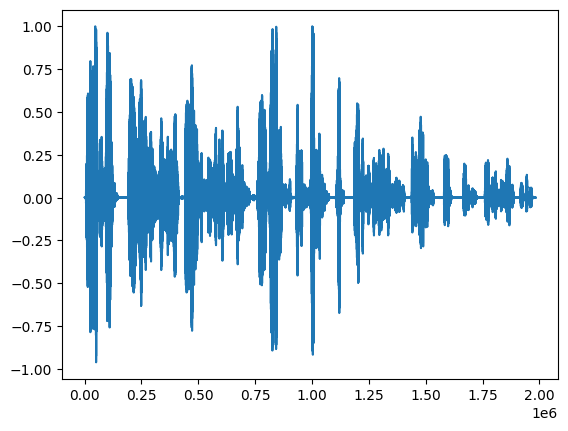

In [2]:
lazy = tfio.audio.AudioIOTensor(path)  #Only key data loaded
sr = lazy.rate.numpy()                 #This calls the sampling rate and transforms it to float since it is a 0-D tensor

print("Shape of the audio vector:",lazy.shape.numpy()) #Calling the shape and transforms it to vector since it's a 1-D tensor
print("Sampling rate :", sr, "Hz")

# Re-sample to the baseline: 44100Hz
if sr != base_sr:   # If we have a different sampling size than the baseline
    lazy = tf.audio.resample(lazy, lazy.rate.numpy(), base_sr)
    print("Audio file was resampled to {}Hz sample rate".format(base_sr))

tensor = tf.cast(lazy.to_tensor(), tf.float32) / np.max(lazy.to_tensor().numpy()) # Calling the data and normalizing
print(tensor.shape)
plt.plot(tensor.numpy()) #Vizualizing

## 1.b. Trim the data accordingly

In [4]:
# - Modify the parameters at will -------------------------
begin = 5   #Start cut in seconds
end = 50    #End cut in seconds

(1984500,)


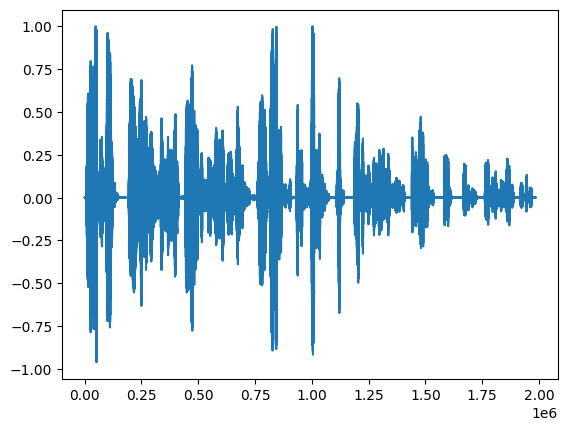

In [5]:
tensor = tf.squeeze(tensor, axis=[-1], name="Squeezing")        # Squeeze the vector to manipulate more easily.
tensor = tensor[int(begin*base_sr):int(end*base_sr)]         # Trim the tensor
plt.plot(tensor.numpy())                                     # Check your cut
print(tensor.shape)

# 2. Making the Dataset

In [3]:
# I recommend not to modify those parameters, as they mimic the precision of Praat parameters.
window_length = int(0.005*base_sr)      # Length of the FFT window
window_stride = int(0.002*base_sr)      # Stride of the window
window_overlap = window_length-window_stride    #self-explanatory

(221, 22531)


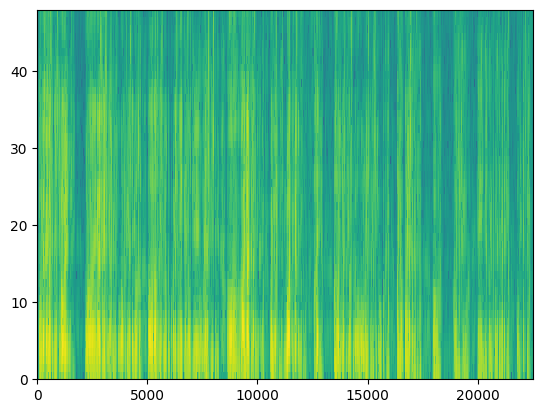

In [4]:
tensor = tf.squeeze(tensor, axis=[-1], name="Squeezing")        # Squeeze the vector to manipulate more easily.
spec = tfio.audio.spectrogram(tensor, nfft=2*window_length, window=window_length, stride=window_stride)

image = tf.transpose(spec)
print(image.shape)
plt.pcolormesh(tf.math.log(image).numpy())   #pcolormesh to have a "raw" image, without interpolation


max_freq = 22000        # The maximum frequency on the spectrogram
freq_coef = image.shape[0]/max_freq     # Coef to transform frequencies to pixels along the y-axis
plt.ylim(0, 48)

time = tensor.shape[0]/base_sr
time_coef = image.shape[1]/time         # Coef to transform seconds to pixels along the x-axis

np.save("miscellaneous/spectro_{}".format(key), tf.math.log(image).numpy())   # This saves the full spectrogram to be later used to zoom into some regions of variable length in time.

In [5]:
# Making the individual samples

#seg_length = int(duration*time_coef)  #Transform in length for the vector
seg_length = 2504
samples_id = np.random.randint(0, image.shape[1]-seg_length, nb_samples)    # Draw random samples
np.save("miscellaneous/spectrogram_indices_{}".format(key), samples_id)                   # Saves the position of the images in the original full spectrogram
np.save("miscellaneous/time_stamps_{}.npy".format(key), samples_id/time_coef)             # Saves the equivalent time stamps from the positions

for i,index in enumerate(samples_id):
    np.save("dataset_vector_{}/{}_{}.npy".format(key, key, i), spec[index:index+seg_length, :48])